# HyperSpy Fitting tutorial

This tutorial shows the basics of model (currently only 1D) fitting in HyperSpy from the grounds up. All data is artificial and can be generated by running the code <a href='#two_peaks'>at the end</a> of the notebook.

__Required version:__

    HyperSpy 1.3

## Author:

13/04/2015 Tomas Ostasevicius - Developed for HyperSpy workshop at University of Cambridge

01/06/2016 Tomas Ostasevicius - updated and expanded for HyperSpy workshop at Scandem conference 2016

22/07/2016 Tomas Ostasevicius - updated for HyperSpy version 1.0

09/05/2019 Andrew Herzing - Modified for NIST Hyperspy Tutorial

<a id='top'></a>
## Contents:


1. General:
    - <a href='#terms'>The HyperSpy model - component - parameter relationship</a> 
    - <a href='#importing'>Importing HyperSpy</a> 
    - <a href='#how_do_i'>How to find things and autocompletion</a>
1. For fitting
  1. Data -> Model
      - <a href='#loading'>Loading a dataset</a>
      - <a href='#creating_model'>Creating a model</a>
  1. Components
      - <a href='#creating_components'>Creating components</a>
      - <a href='#adding_comps'>Adding components to a model</a>
      - <a href='#renaming_components'>Renaming components</a>   
  1. Parameters and values
      - <a href='#checking_values'>Displaying parameter values</a>
      - <a href='#setting_values'>Setting parameter values</a>
      - <a href='#adjust_position'>Adjustin positions of peaks with a mouse</a>   
  1. Fitting
      - <a href='#fit'>Fitting a single signal</a>
      - <a href='#multifit'>Fitting multiple spectra</a>    
  1. After fit
      - <a href='#plot_components'>Plotting individual components</a>
      - <a href='#plot_parameter'>Plotting parameter maps</a>
      - <a href='#statistics'>Statistical analysis of fitting results</a>
1. (Slightly more) Advanced:
    - <a href='#expression'>Writing your own components</a>
1. Addendum: Generating the synthetic data:
    - <a href='#two_peaks'>Two peaks</a>
    - <a href='#wobbly_peak'>Wobbly peak</a>

<a id='terms'></a>
### Terminology and relationships
<a href='#top'>[back to top]</a> 

In order to use fitting in HyperSpy more effectively, it is useful to understand our structure for curve fitting.

There are three main things, related to fitting:

__1. Model__
can be thought of as a simple box (cooking pot), where we have to put our ingredients. Without anything inside, it is not of much use in this case. Once we add some things to it and mix it a bit (do the actual fitting), however, we have our complete dish!

__2. Component__ is the main building block (ingredient) of our model. Here we mix and match what components we need (or want) for the particular case of signal. 

Examples: 
- Lorentzian (Cauchy)
- Gaussian
- Voigt (a combination of Lorentzian and Gaussian)
- Offset (i.e. constant background)
- Exponential function
- ...
- [create your own or use the very specialised ones!]

Each of the components is ultimately just a function that has variables that change the (shape of the) output. Such a variable in HyperSpy is called a __parameter__


__3. Parameter__ is the knob that the fitting routine adjusts for a good fit. Each component must include at least one parameter in order to be able to change when fitting. A parameter is also the object that we may limit or have to adjust when the result of the fit is not satisfactory. 

Ultimately, a parameter is the only important thing, as far as the fitting is concerned - components are just smart and convenient boxes to combine parameters into functions, and a model is just a box for a collection of components.

For now, let's just keep the rough structure in our heads and look at other things!



<a id='importing'></a>
### Importing
<a href='#top'>[back to top]</a> 

HyperSpy, like many other Python libraries, first has to be imported in your Python setup in order to be used.
Once it is, all the relevant commands can be looped up using the autocompletion feature of the IPython. 

Lets import the HyperSpy and set up plotting.

In [1]:
%matplotlib notebook
import hyperspy.api as hs

<a id='how_do_i'></a>
### How do I .... again?
<a href='#top'>[back to top]</a> 

Once imported, all the HyperSpy commands are available via the 
> `hs.<something>`

interface. You can also look for the help with any Python object like this
> `help(<something>)`

In [104]:
help(hs)

Help on module hyperspy.api in hyperspy:

NAME
    hyperspy.api - All public packages, functions and classes are available in this module.

DESCRIPTION
    When starting HyperSpy using the ``hyperspy`` script (e.g. by executing
    ``hyperspy`` in a console, using the context menu entries or using the links in
    the ``Start Menu``, the :mod:`~hyperspy.api` package is imported in the user
    namespace as ``hs``, i.e. by executing the following:
    
        >>> import hyperspy.api as hs
    
    
    (Note that code snippets are indicated by three greater-than signs)
    
    We recommend to import the HyperSpy API as above also when doing it manually.
    The docstring examples assume that `hyperspy` has been imported as `hs`,
    numpy as ``np`` and ``matplotlib.pyplot`` as ``plt``. 
    
    Functions:
    
        create_model
            Create a model for curve fitting.
    
        get_configuration_directory_path
            Return the configuration directory path.
    
     

In [105]:
help(hs.model.components1D)

Help on module hyperspy.components1d in hyperspy:

NAME
    hyperspy.components1d - Components that can be used to define a 1D model for e.g. curve fitting.

DESCRIPTION
    There are some components that are only useful for one particular kind of signal
    and therefore their name are preceded by the signal name: eg. eels_cl_edge.
    
    Writing a new template is really easy, just edit _template.py and maybe take a
    look to the other components.
    
    For more details see each component docstring.
    Arctan                    Arctan function component..
    Bleasdale                 Bleasdale function component...
    DoublePowerLaw            ..
    EELSCLEdge                EELS core loss ionisation edge from hydroge..
    Erf                       Error function component..
    Exponential               Exponentian function components..
    Expression                Create a component from a string expression..
    Gaussian                  Normalized gaussian function co

<a id='loading'></a>
### Fitting in HyperSpy (detailed)
<a href='#top'>[back to top]</a> 

First you should have a spectrum (a particular kind of the `Signal` subclass!) you want to fit. Let's load a synthetic dataset with some curves named 
> `"two_peaks.hspy"`

and have a look at it.

If you can't load the dataset, it means you most likely have not generated it yet. Please run the two cells <a href='#two_peaks'>at the end</a> of the notebook to do so.

In [106]:
s = hs.load("data/two_peaks.hspy")

In [107]:
s

<Signal1D, title: Two gaussians, dimensions: (|1024)>

<IPython.core.display.Javascript object>


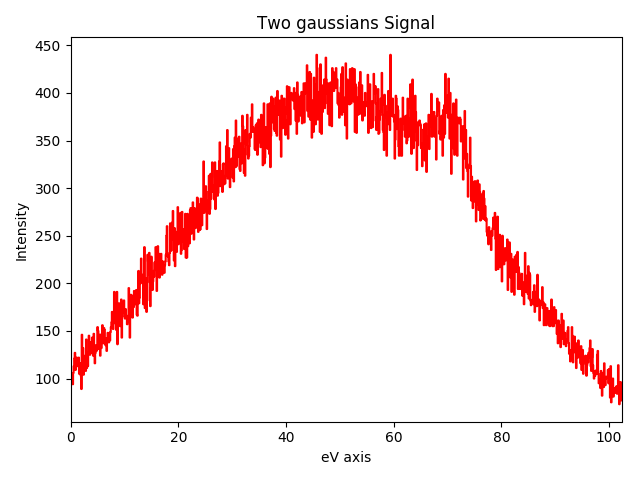

In [108]:
s.plot()

<a id='creating_model'></a>
<a href='#top'>[back to top]</a> 

Creating a model now is simple - just pass the spectrum to the function 
> `model_reference = signal_reference.create_model()`

Let's reference the model by "`m`".

In [109]:
m = s.create_model()

Let's look what's inside:

In [110]:
m.components

   # |      Attribute Name |      Component Name |      Component Type
---- | ------------------- | ------------------- | -------------------

As we can see, the model is still empty. That will not always be the case - for some types of signals, an automatic background component is added when creating a model, hence it's always good to check.

We can plot the model in exactly the same way as the signal:

<IPython.core.display.Javascript object>


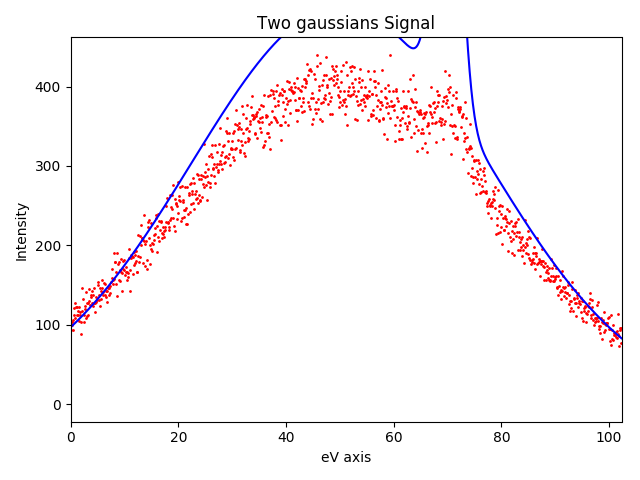

In [111]:
m.plot()

The only difference from the model plot is that each data point is displayed individually. 

<a id='creating_components'></a>
<a href='#top'>[back to top]</a> 

To do anything with the model, we should __create__ some __components__ and add them. Let's create two gaussians, referenced as "g1" and "g2":

-----------------
P.S.: keep in mind that creating a component is a function - hence there should be brackets at the end! Such as 
> `our_component_reference = hs.model.components1D.example_component()`

In [112]:
# Give some sensible defaults to the two components when they're created
g1 = hs.model.components1D.GaussianHF(height=400, centre=50.0, fwhm=60)
g2 = hs.model.components1D.GaussianHF(height=30, centre=70, fwhm=5)

<a id='adding_comps'></a>
<a href='#top'>[back to top]</a> 

... and __add the components to__ our __model__. For that there are generally two ways:

Individually
> `our_model_reference.append(our_component_reference)`

or in lists (i.e. grouped by square brackets)
> `our_model_reference.extend([first_component_reference, second_component_reference])`

In [113]:
m.extend([g1, g2])

Let's check how the model looks now:

In [114]:
m.components

   # |      Attribute Name |      Component Name |      Component Type
---- | ------------------- | ------------------- | -------------------
   0 |          GaussianHF |          GaussianHF |          GaussianHF
   1 |        GaussianHF_0 |        GaussianHF_0 |          GaussianHF

<a id='renaming_components'></a>
<a href='#top'>[back to top]</a> 

For our convenience we can __rename__ the __components__ as we choose, for example "large" and "small" (note that the "g1" and "g2" are only references we created for them, not names of the components)

In [115]:
g1.name = "large"
g2.name = "small"

We can look at the model again to see the result

In [116]:
m.components

   # |      Attribute Name |      Component Name |      Component Type
---- | ------------------- | ------------------- | -------------------
   0 |               large |               large |          GaussianHF
   1 |               small |               small |          GaussianHF

<a id='checking_values'></a>
<a href='#top'>[back to top]</a>

To finally see the full structure (the one we looked at <a href='#terms'>here</a>), we can __print all of the parameter values__ of all components of the model.

In [117]:
m.print_current_values()

Components	Parameter	Value
large
		centre	50
		fwhm	60
		height	400
small
		centre	70
		fwhm	5
		height	30


To access the values, we have to look inside the components for the parameters. It can simply be done by following the pattern:
> `some_component_reference.parameter_name.value`

In this case the component references are the __g1__ and __g2__, while parameter names are __centre__, __A__ and __sigma__.

In [118]:
g1.fwhm.value

60.0

<a id='setting_values'></a>
<a href='#top'>[back to top]</a>

We can __set parameter values__ in exactly the same way. Let set `g1` `sigma` value to 30:

In [119]:
g1.fwhm.value = 65

In [120]:
m.print_current_values()

Components	Parameter	Value
large
		centre	50
		fwhm	65
		height	400
small
		centre	70
		fwhm	5
		height	30


For convenience, we can also __set values "in bulk"__ for all components in the model. The required command is
> `m.set_parameters_value`

Set the area ("A" parameter) of both peaks to 500

In [121]:
m.set_parameters_value('height', 500)

In [122]:
m.print_current_values()

Components	Parameter	Value
large
		centre	50
		fwhm	65
		height	500
small
		centre	70
		fwhm	5
		height	500


<a id='adjust_position'></a>
<a href='#top'>[back to top]</a>

When using HyperSpy in a notebook (like this one), we can also use additional functions to adjust parameters with a mouse (interactively).

In order to enable it, call __`.notebook_interaction()`__ for either model, component or parameter directly:

<IPython.core.display.Javascript object>


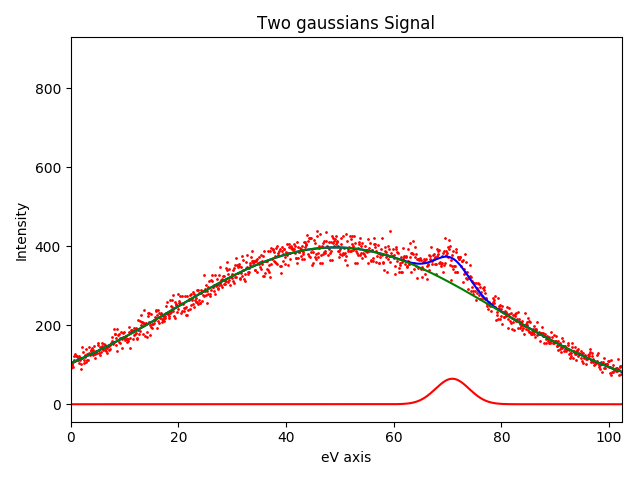

In [123]:
m.plot(True)

The small peak is much too large, so use the `.gui()` command to set the height of the small peak down to something more reasonable:

In [124]:
m.gui()

Accordion(children=(VBox(children=(Checkbox(value=True, description='active'), HBox(children=(FloatText(value=…

We'll set the small peak's height explicitly so everyone starts with the same initial conditions:

In [125]:
g2.height.value = 50

<a id='fit'></a>
<a href='#top'>[back to top]</a>

Finally, let's __fit__ the our __model__ and plot it afterwards to see how well (or poorly) we did

In [126]:
m.fit()

In [127]:
m.print_current_values()

Components	Parameter	Value
large
		centre	49.0963
		fwhm	70.6352
		height	397.187
small
		centre	70.8859
		fwhm	7.3363
		height	64.6381


<IPython.core.display.Javascript object>


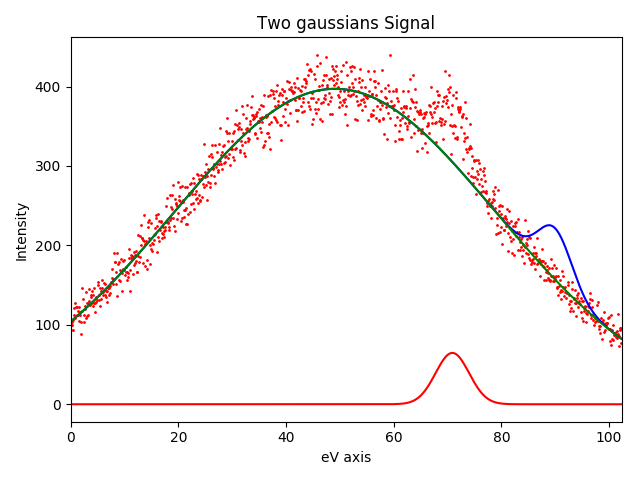

In [129]:
m.plot(True)

<a id='multifit'></a>

Fitting many signals
---------------------
<a href='#top'>[back to top]</a>


When the signal is a collection of spectra (e.g. EELS / EDS), we can fit all of them automatically (sequentially).

First load the spectrum `smoothly_moving_peaks.hspy`, reference  it as `s2` and create a new model for it `m2`:

In [2]:
s2 = hs.load('data/smoothly_moving_peaks.hspy')
m2 = s2.create_model()

We can still use the two components we had in the previous part ( `g1` and `g2`), so let's just add them to the new model and plot it to see what it looks like:

In [3]:
# Give some sensible defaults to the two components when they're created
g1 = hs.model.components1D.GaussianHF(height=400, centre=50.0, fwhm=60)
g2 = hs.model.components1D.GaussianHF(height=30, centre=70, fwhm=5)

g1.name = "large"
g2.name = "small"

m2.extend([g1,g2])

<IPython.core.display.Javascript object>


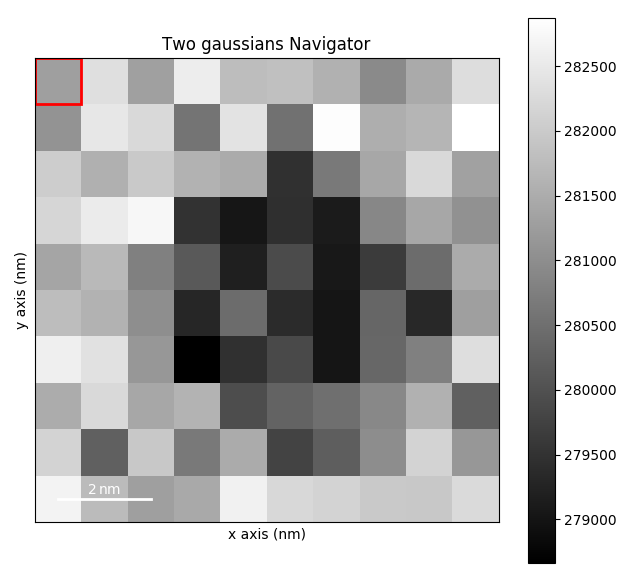

<IPython.core.display.Javascript object>


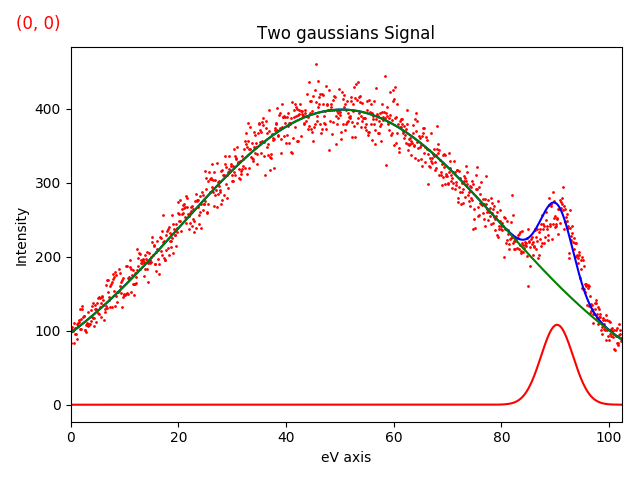

In [5]:
m2.plot(True)

In [6]:
g1.centre.value = 50
g1.fwhm.value = 60
g1.height.value = 400
g2.centre.value = 85
g2.height.value = 100
g2.fwhm.value = 7

We can see that the small peak is not where it should be, so just adjust its position as previously

In [7]:
m2.fit(fitter="Nelder-Mead")

In [8]:
m2.print_current_values()

Components	Parameter	Value
large
		centre	50.0125
		fwhm	70.4902
		height	397.803
small
		centre	91.2162
		fwhm	7.03459
		height	104.268


In [9]:
m2.assign_current_values_to_all()

Now we can perform a fit for all of the signals sequentially by passing command
> `m2.multifit()`

Even though it slows HyperSpy down, it is useful (for now!) to have the model plot windows open when the command is passed:

- In the signal widow you can see (however briefly) all of the signals and the corresponding fit
- In the navigator window you can track the order the signals are being fitted. If you end up using this feature often, you'll notice that it has a huge impact on the accuracy of the results if chosen poorly. The next HyperSpy version (1.0) will have an automatic routine "SAMFire" to do that in a smart way, hence enabling much more complex models to be fitted effortlessly.

In [10]:
m2.multifit(fitter="Nelder-Mead")

<a id='plot_components'></a>
<a href='#top'>[back to top]</a>

We can see the total result of the fit, however it is often useful to see each component individually


<IPython.core.display.Javascript object>


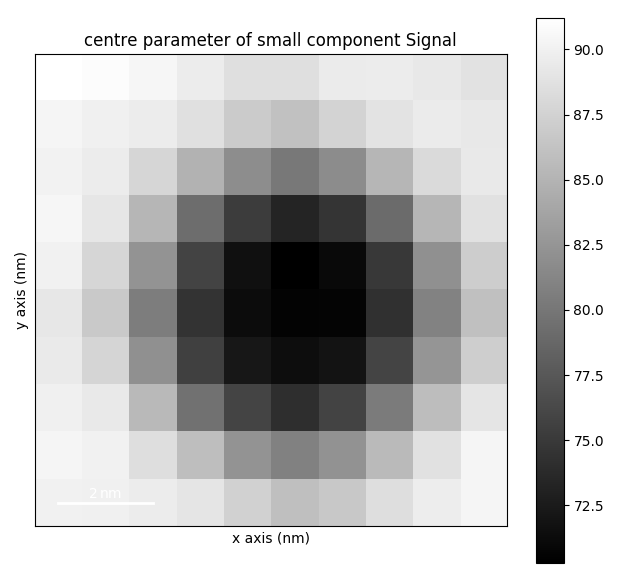

<IPython.core.display.Javascript object>


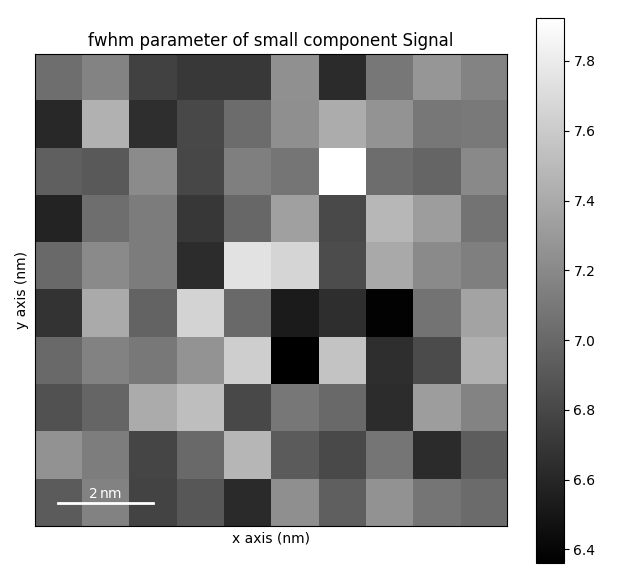

<IPython.core.display.Javascript object>


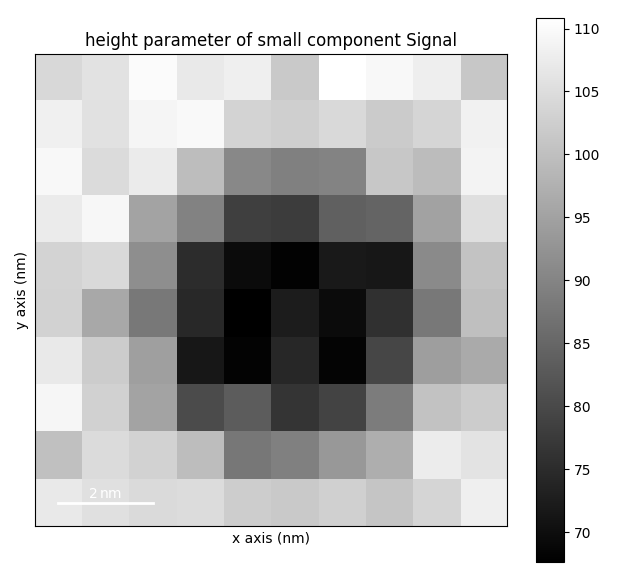

In [11]:
g2.plot()

<IPython.core.display.Javascript object>


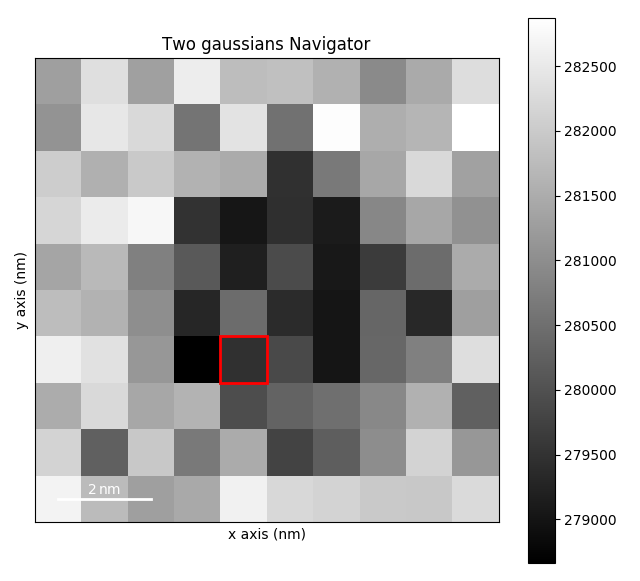

<IPython.core.display.Javascript object>


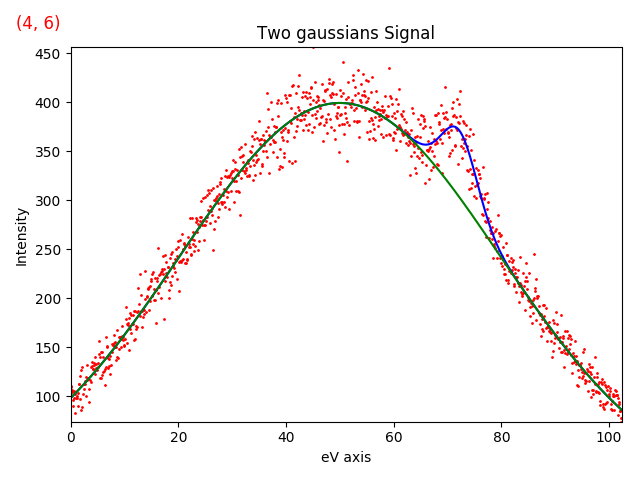

In [12]:
m2.plot(True)

In [209]:
m2.fit(bounded=True)

<a id='plot_parameter'></a>
<a href='#top'>[back to top]</a>

Now that we have the artificial spectral image (SI) fitted, we can look at it however we want! For example, when fitting, you might have noticed that the position of the small peak shifted from pixel to pixel. We can __plot__ the centre __parameter__ of the component to have a look at it:

<IPython.core.display.Javascript object>


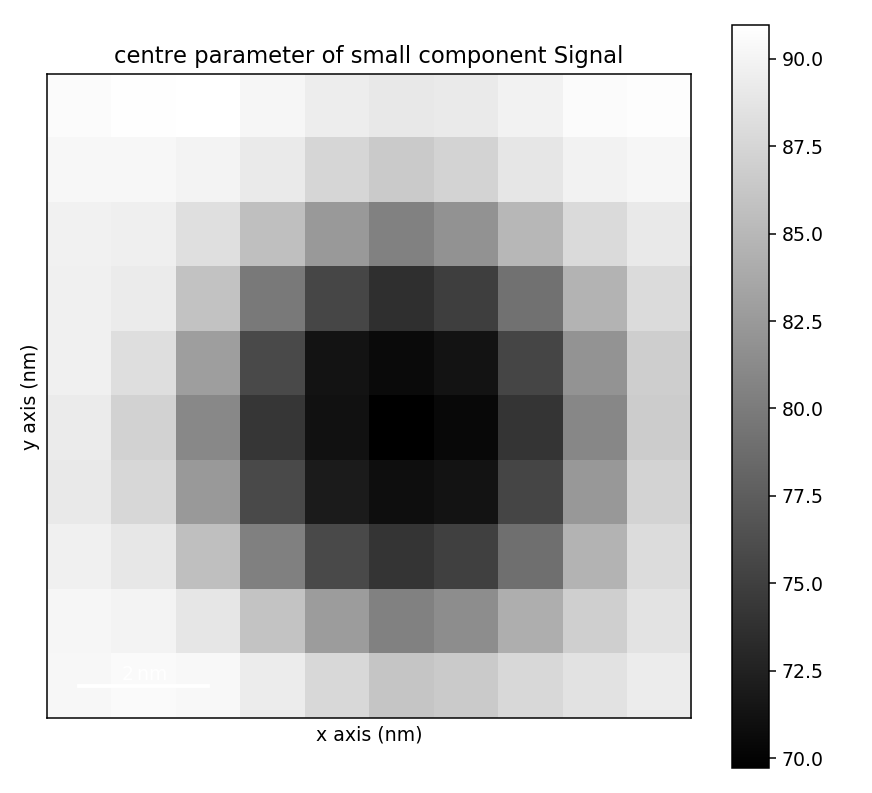

In [31]:
g2.centre.plot()

<a id='statistics'></a>

Statistical analysis of fitting results
---------------------
<a href='#top'>[back to top]</a>

Once the fit was performed, chi-squared ($\chi^2$), degrees of freedom and reduced chi-squared of the fit are automatically calculated.

They are accessible with, respectively:
> `m2.chisq`

> `m2.dof`

> `m2.red_chisq`

Let's have a look at reduced $\chi^2$ by plotting it

<IPython.core.display.Javascript object>


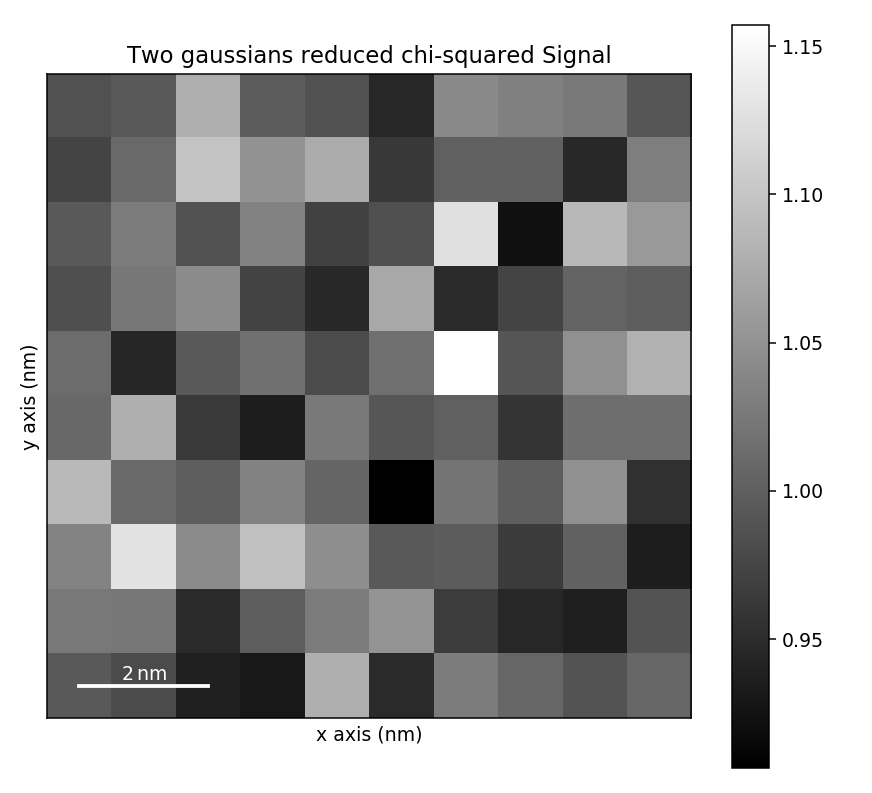

In [32]:
m2.red_chisq.plot()

We can see that the map looks relatively uniform (albeit with some noise, as expected). The colorbar scale tells us that all of the points fall in the (0.9, 1.15) range, which shows a good fit.

We can of course plot the histogram of the same data like so:

<IPython.core.display.Javascript object>


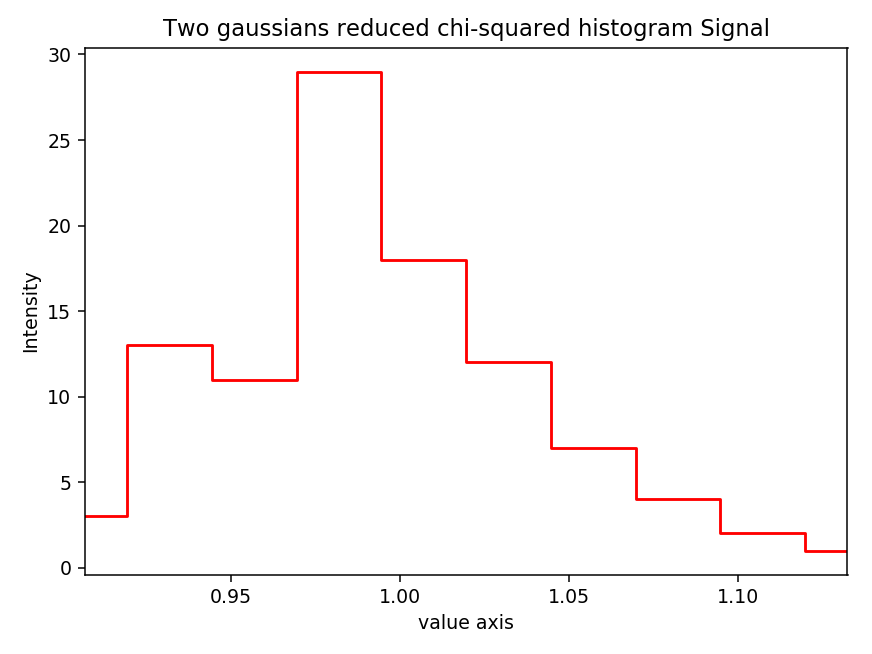

In [33]:
m2.red_chisq.get_histogram().plot()

<a id='expression'></a>

More interesting components
---------------------
<a href='#top'>[back to top]</a>



Lets say we have a slightly stranger signal that we want to fit, like this one:

In [34]:
s = hs.load('data/wobbly_peak.hspy')

<IPython.core.display.Javascript object>


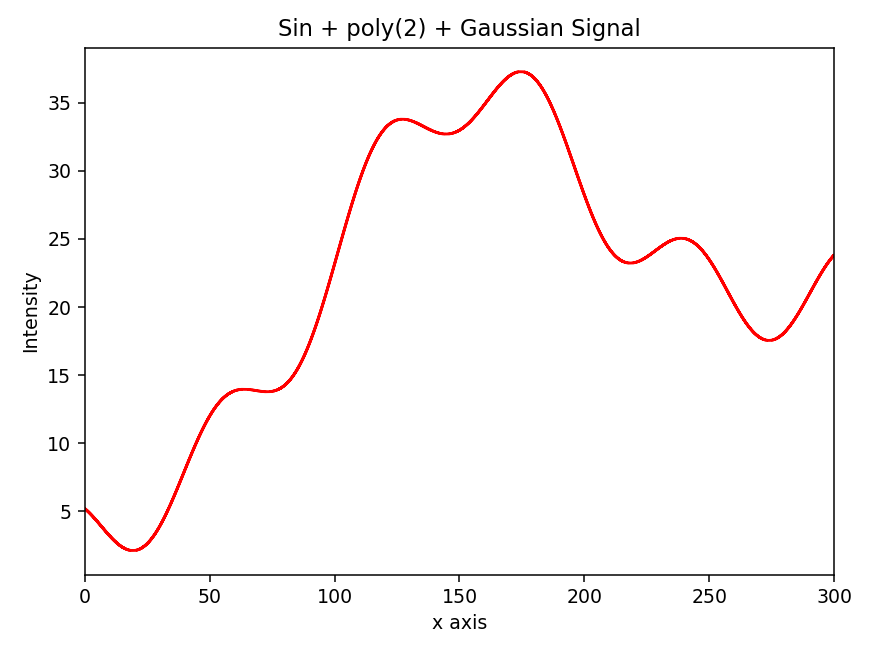

In [35]:
s.plot()

It's (as the name implies) composed of a sinus + gaussian + 2nd degree polynomial. However we don't have a `sin` component in the in-build library, so we'll just write our own:

In [36]:
sin = hs.model.components1D.Expression('A*sin(b*x + c)',
                                        name='sin',)

Then just create and add all the additional components we might need: a gaussian and a polynomial

In [37]:
m = s.create_model()
gaus = hs.model.components1D.Gaussian()
poly = hs.model.components1D.Polynomial(2)
m.extend([sin, gaus, poly])

In [38]:
m.print_current_values()

Components	Parameter	Value
sin
		A	0
		b	0
		c	0
Gaussian
		A	1
		centre	0
		sigma	1
Polynomial
		coefficients[0]	0
		coefficients[1]	0
		coefficients[2]	0


The initial values do not seem to be very useful, so let's just plot the model, turn on the widgets, and we'll play until things seem close enough:

<IPython.core.display.Javascript object>


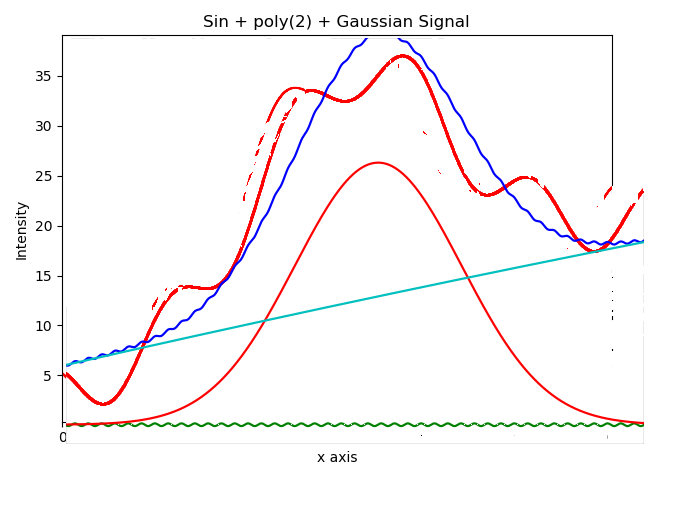

Accordion(children=(VBox(children=(Checkbox(value=True, description='active'), HBox(children=(FloatText(value=…

In [43]:
m.plot(True)

m.gui()

And then fit it and look at the results!

In [41]:
m.fit()

In [42]:
m.print_current_values()

Components	Parameter	Value
sin
		A	-0.0434954
		b	0.910507
		c	15.8544
Gaussian
		A	3137.94
		centre	149.714
		sigma	51.5162
Polynomial
		coefficients[0]	-1.18727e-05
		coefficients[1]	0.0643952
		coefficients[2]	2.11948


# Generating synthetic data

<a id='two_peaks'></a>
## Two peaks
<a href='#top'>[back to top]</a> 


In [ ]:
from scipy.ndimage import gaussian_filter
import numpy as np
import hyperspy.api as hs
# set the parameters:
blurs = [0., 1.]
radius = 3  #radius of a different region
domain = 10 #size of the square domain
small_centres = (500, 900)
small_amplitudes = (8000,  5000)

# work:
total = None
cent = (domain//2, domain//2)
y,x = np.ogrid[-cent[0]:domain-cent[0], -cent[1]:domain-cent[1]]
mask = x*x + y*y <= radius*radius
for blur in blurs:

    s = hs.signals.Signal1D(np.ones((domain,domain, 1024)))
    cent = tuple([int(0.5*i) for i in s.data.shape[:-1]])
    m0 = s.create_model()
    gs01 = hs.model.components1D.Gaussian()
    m0.append(gs01)
    gs01.sigma.value = 300
    gs01.centre.map['values'][:] = (np.random.random((domain,domain)) - 0.5)*50 + small_centres[0]
    gs01.centre.map['is_set'][:] = True
    gs01.A.map['values'][:] = 1000 * np.random.random((domain,domain)) + 300000
    gs01.A.map['is_set'][:] = True

    gs02 = hs.model.components1D.Gaussian()
    m0.append(gs02)
    gs02.sigma.value = 30
    gs02.centre.map['values'][:] = (np.random.random((domain,domain)) - 0.5)*50 +  small_centres[1]

    gs02.centre.map['values'][mask] = (np.random.random(gs02.centre.map['values'][mask].shape) - 0.5)*50 + 700
    #gs02.centre.map['values'][10:20,10:20] = (np.random.random((10,10)) - 0.5)*100 + 200

    gs02.centre.map['values'] = gaussian_filter(gs02.centre.map['values'], blur)
    gs02.centre.map['is_set'][:] = True
    gs02.A.map['values'][:] = small_amplitudes[0]
    gs02.A.map['values'][mask] = small_amplitudes[1]
    gs02.A.map['values'] = gaussian_filter(gs02.A.map['values'], blur)
    gs02.A.map['is_set'][:] = True
    s11 = m0.as_signal()
    if total is None:
        total = s11.data.copy()
    else:
        total = np.concatenate((total, s11.data), axis=1)
        
s = hs.signals.Signal1D(total)
s.metadata.General.author = 'Tomas Ostasevicius'
s.metadata.General.title = 'Two gaussians'

s.add_poissonian_noise()
s.estimate_poissonian_noise_variance()
s.axes_manager[0].name = "x"
s.axes_manager[0].units = "nm"
s.axes_manager[1].name = "y"
s.axes_manager[1].units = "nm"

s.axes_manager[2].name = "Energy"
s.axes_manager[2].name = "eV"
s.axes_manager[2].scale = 0.1

s.inav[5,5].save("two_peaks", overwrite=True)
s.inav[10:20,:].save("smoothly_moving_peaks", overwrite=True)

<a id='wobbly_peak'></a>
## Wobbly peak
<a href='#top'>[back to top]</a> 


In [7]:
import numpy as np
import hyperspy.api as hs

k = 1
alpha = 15
amp = 3

gaus_position = 15
gaus_width = 5
gaus_A = 300

gradient = 0.6
offset= 3

sin_component = hs.model.components1D.Expression('A * sin(k*x + alpha)', name='sin', k=k,
                                               alpha=alpha, A=amp)
gaus = hs.model.components1D.Gaussian(A=gaus_A, sigma=gaus_width, centre=gaus_position)

poly = hs.model.components1D.Polynomial(1)

poly.coefficients.value = (gradient, offset)

axis = np.linspace(0, 30, 3000, dtype='double')

result = sin_component.function(axis)+ gaus.function(axis) + poly.function(axis)
s = hs.signals.Signal1D(result)
s.axes_manager[0].name = 'x'
s.axes_manager[0].scale = 0.1
s.axes_manager[0].offset = 0

s.metadata.General.author = 'Tomas Ostasevicius'
s.metadata.General.title = 'Sin + poly(2) + Gaussian'
s.save('wobbly_peak', overwrite=True)